In [2]:
pip install mysql-connector-python

   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/16.1 MB 11.8 MB/s eta 0:00:02
   ------------- -------------------------- 5.2/16.1 MB 13.9 MB/s eta 0:00:01
   -------------------- ------------------- 8.4/16.1 MB 14.1 MB/s eta 0:00:01
   ---------------------------- ----------- 11.3/16.1 MB 14.1 MB/s eta 0:00:01
   --------------------------------- ------ 13.4/16.1 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 16.1/16.1 MB 13.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Ansshi@1432',
    database='ECOMMERCE'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/singh/Downloads/end to end project/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

db = mysql.connector.connect(host="localhost",
                             username="root",
                             password="Ansshi@1432",
                              database="ecommerce" ) 
cur=db.cursor()


# 1. List all unique cities where customers are located.


In [277]:
query="""select distinct customer_city from customers"""

cur.execute(query)
data=cur.fetchall()
data
df1=pd.DataFrame(data,columns=['distinct_city_name'])
df1.head(3)

,distinct_city_name
0,franca
1,sao bernardo do campo
2,sao paulo


# 2. Count the number of orders placed in 2017.


In [95]:
query="""select count(*) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)

data=cur.fetchall()
print(f"total order placed in 2017 are {data[0][0]}")

total order placed in 2017 are 45101


# 3. Find the total sales per category.


In [272]:
query="""select upper(products.product_category) as category, round(sum(payments.payment_value),2) as sales
from products join order_items on 
products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id
group by category"""

cur.execute(query)
data=cur.fetchall()
data
df3=pd.DataFrame(data,columns=['category','sale_value'])
df3.isnull().sum()

category      1
sale_value    0
dtype: int64

In [279]:
import warnings
warnings.filterwarnings("ignore")


In [283]:
df3['category'].fillna(df3['category'].mode()[0], inplace=True)
df3.isnull().sum()
df3.head()

,category,sale_value
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67


 # 4. Calculate the percentage of orders that were paid in installments.


In [286]:
query="""select (sum(
case when payment_installments >=1 then 1 else 0 end ))/count(*)*100  from payments"""

cur.execute(query)
data=cur.fetchall()
print(f"percentage of order that are paid in installments {data[0][0]}")

percentage of order that are paid in installments 99.9981


# 5. Count the number of customers from each state. 


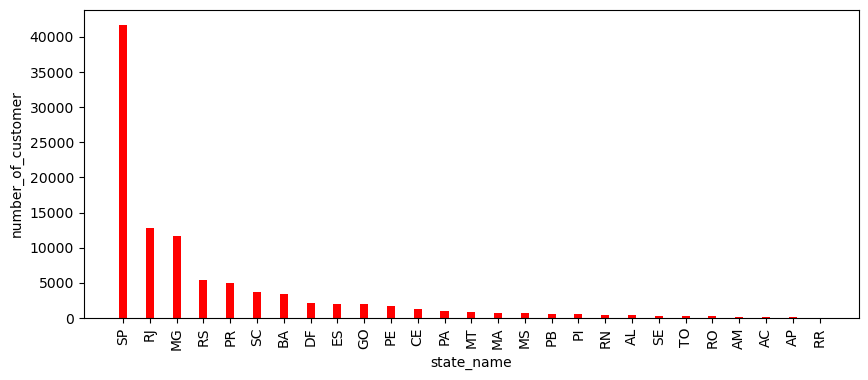

In [289]:
query="""select customer_state,count(*)as number_of_customer from customers
group by customer_state order by number_of_customer desc"""

cur.execute(query)
data=cur.fetchall()
df5=pd.DataFrame(data,columns=['state_code','num_customer'])

plt.figure(figsize=(10,4))
plt.bar(df5['state_code'],df5['num_customer'],color='r',width=0.3)
plt.xlabel("state_name")
plt.ylabel("number_of_customer")
plt.xticks(rotation = 90)
plt.show()

# 6. Calculate the number of orders per month in 2018.


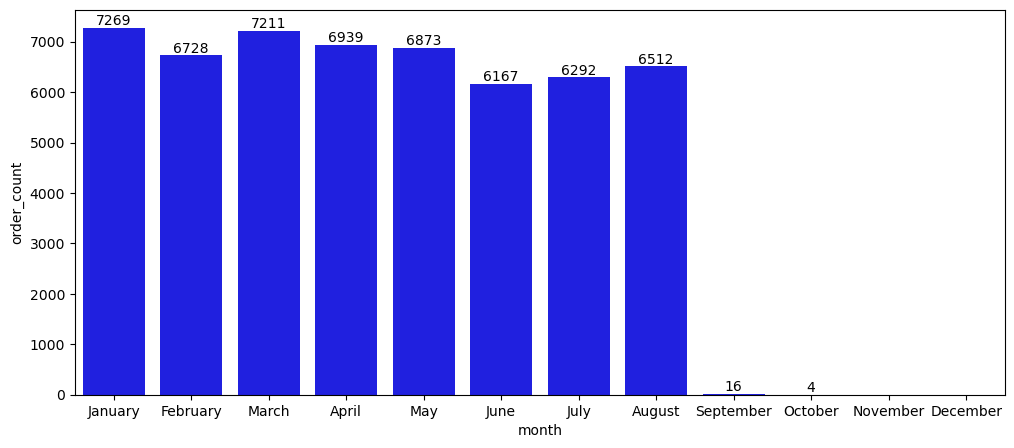

In [348]:
import seaborn as sns
query=""" select monthname(order_purchase_timestamp) as month,count(order_id)as order_count from orders where year(order_purchase_timestamp)=2018
group by month"""

cur.execute(query)
data=cur.fetchall()
df6=pd.DataFrame(data,columns=['month','order_count'])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]
plt.figure(figsize=(12,5))

t=sns.barplot(x=df6['month'], y=df6['order_count'], data=df6, order=o,color='b')
t.bar_label(t.containers[0])
plt.show()


# 7. Find the average number of products per order, grouped by customer city.


In [368]:
query="""with count_per_order as (select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items on
orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) as avg_order_product
from customers join count_per_order on
customers.customer_id=count_per_order.customer_id
group by customers.customer_city """


cur.execute(query)
data=cur.fetchall()

df7=pd.DataFrame(data,columns=['city_name','avg_order'])
df7

,city_name,avg_order
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15
...,...,...
4105,buriti,3.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


# 8. Calculate the percentage of total revenue contributed by each product category.


In [378]:
query="""select products.product_category as category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales
from products join order_items on 
products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id
group by category
order by sales desc;
"""

cur.execute(query)
data=cur.fetchall()
df8=pd.DataFrame(data,columns=['product_category','percentage_revenue'])
df8.head()


,product_category,percentage_revenue
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


# 9. Identify the correlation between product price and the number of times a product has been purchased.


In [389]:
query="""select products.product_category,count(order_items.product_id)as number_of_order_placed,round(avg(order_items.price),2)as avg_price from products join
order_items on
products.product_id=order_items.product_id
group by products.product_category;"""

cur.execute(query)
data=cur.fetchall()
df9=pd.DataFrame(data,columns=['product_category','order_count','avg_price'])
df9.head()

,product_category,order_count,avg_price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14


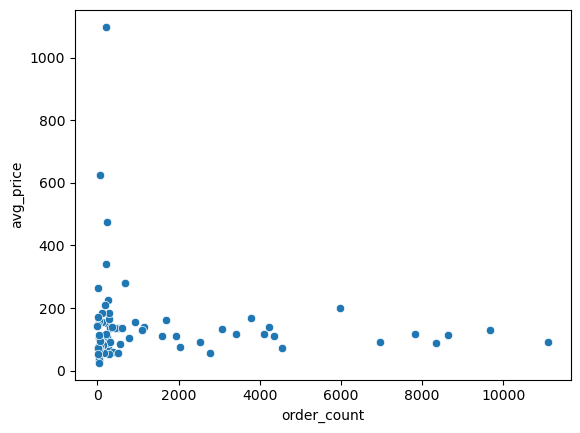

In [395]:
x=df9[['order_count']]
y=df9['avg_price']
sns.scatterplot(x='order_count',y='avg_price',data=df9)
plt.show()

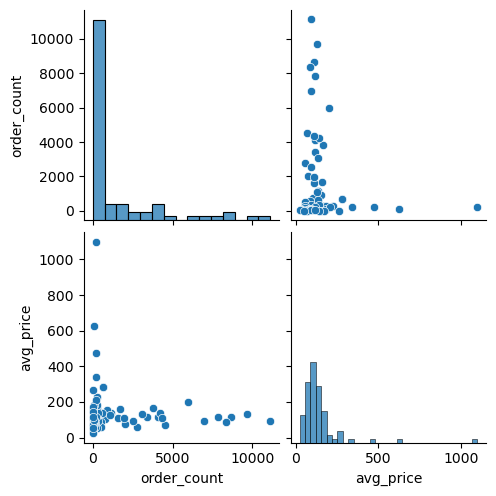

In [401]:
sns.pairplot(df9)

# 10. Calculate the total revenue generated by each seller, and rank them by revenue.


In [436]:
query="""select*,dense_rank() over (order by revenue desc)as Ranks from
(select order_items.seller_id,round(sum(payments.payment_value),2) as revenue from payments
 join  order_items on
 payments.order_id=order_items.order_id
 group by seller_id)as a;"""

cur.execute(query)
data=cur.fetchall()
df10=pd.DataFrame(data,columns=['seller_id','revenue','rank'])
print(f"Total number of rows is {df10.shape[0]}")

df10.head()

Total number of rows is 3095


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


# 11. Calculate the moving average of order values for each customer over their order history.


In [452]:
query=""" select customer_id,order_purchase_timestamp,payment,avg(payment) over(partition by customer_id
 order by order_purchase_timestamp
 rows between 2 preceding and current row)as moving_avg from
 (select orders.customer_id,orders.order_purchase_timestamp, payments.payment_value as payment
 from payments join orders on
 payments.order_id=orders.order_id)as an;"""


cur.execute(query)
data=cur.fetchall()
df11=pd.DataFrame(data,columns=['customer_id','purchase_date_time','payment','moving_avg'])
print(f"The number of rows{df11.shape[0]} and the number of columns is {df11.shape[1]}\n")
df11.head(5)

The number of rows103886 and the number of columns is 4



,customer_id,purchase_date_time,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# 12. Calculate the cumulative sales per month for each year.


In [458]:
query="""select years,months,payment,sum(payment)over(order by years,months)as cumulative_sales from
 (select year(orders.order_purchase_timestamp)as years,month(orders.order_purchase_timestamp) as months,
 round(sum(payments.payment_value),2) as payment from orders join payments on
 orders.order_id=payments.order_id
 group by years,months order by years,months) as n; """

cur.execute(query)
data=cur.fetchall()
df12=pd.DataFrame(data,columns=['year','month','sale_value','cumulative_sale_value'])
df12.head()


,year,month,sale_value,cumulative_sale_value
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# 13. Calculate the year-over-year growth rate of total sales.


In [470]:
query="""with a as (select year(orders.order_purchase_timestamp)as years,
 round(sum(payments.payment_value),2) as payment from orders join payments on
 orders.order_id=payments.order_id
 group by years order by years)
 select years,payment,
 round(((payment-lag(payment,1) over(order by years))/ lag(payment,1) over(order by years))*100,2) as yoy__growth
 from a;"""
cur.execute(query)
data=cur.fetchall()
df13=pd.DataFrame(data,columns=['year','payment','YOY_growth%(Y=YEAR)'])
df13

,year,payment,YOY_growth%(Y=YEAR)
0,2016,59362.34,NaN
1,2017,7249746.73,12112.7
2,2018,8699763.05,20.0


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [496]:
query="""with a as(select customers.customer_id,min(orders.order_purchase_timestamp)as first_order from customers join orders on
customers.customer_id=orders.customer_id
group by customers.customer_id),
b as (select a.customer_id,count(distinct orders.order_purchase_timestamp)as next_order from a join orders on
 orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) as retention_rate
from a left join b on
a.customer_id=b.customer_id;"""

cur.execute(query)
data=cur.fetchall()
print(f"retention rate of customer is {data[0]}")

retention rate of customer is (None,)


# 15. Identify the top 3 customers who spent the most money in each year.

In [505]:
query="""with ranked_customer as(select years,customer_id,payment,dense_rank() over(partition by years order by payment desc) as d_rank from
(select year(orders.order_purchase_timestamp)as years,orders.customer_id,
round(sum(payments.payment_value),2)as payment from orders join payments on
orders.order_id=payments.order_id
group by years,orders.customer_id) as a)
 
 select*from ranked_customer where d_rank<=3;"""

cur.execute(query)
data=cur.fetchall()
df15=pd.DataFrame(data,columns=['year','customer_id','payment','rank'])
df15

,year,customer_id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3
